In [1]:
#importing require python classes and packages


import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, Model, load_model
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
c:\users\pooja\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\pooja\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\pooja\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define class labels from the dataset
path = "Dataset/Face"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())  
print("Person ID Class Labels : "+str(labels))        

Person ID Class Labels : ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
#load multimodal dataset images like face, finger and iris
if os.path.exists("model/faceX.txt.npy"):
    face_X = np.load("model/faceX.txt.npy")
    face_Y = np.load("model/faceY.txt.npy")
    finger_X = np.load("model/fingerX.txt.npy")
    finger_Y = np.load("model/fingerY.txt.npy")
    iris_X = np.load("model/irisX.txt.npy")
    iris_Y = np.load("model/irisY.txt.npy")
else:
    face_path = "Dataset/Face"
    finger_path = "Dataset/FingerVein"
    iris_path = 'Dataset/Iris'
    face_X = []
    face_Y = []
    finger_X = []
    finger_Y = []
    iris_X = []
    iris_Y = []
    #load face imageshttps://chatgpt.com/share/aed3c9c7-87a0-42e1-9ebf-a0a82a4fa80c
    for root, dirs, directory in os.walk(face_path):#loading face images=====
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])
                img = cv2.resize(img, (32,32))3#resize images
                face_X.append(img)
                face_Y.append(int(name)-1)
    face_X = np.asarray(face_X)
    face_Y = np.asarray(face_Y)
    np.save("model/faceX.txt",face_X)
    np.save("model/faceY.txt",face_Y)
    for root, dirs, directory in os.walk(finger_path):#load finger image=========
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])
                img = cv2.resize(img, (32,32))
                finger_X.append(img)
                finger_Y.append(int(name)-1)
    finger_X = np.asarray(finger_X)
    finger_Y = np.asarray(finger_Y)
    np.save("model/fingerX.txt",finger_X)
    np.save("model/fingerY.txt",finger_Y)
    for root, dirs, directory in os.walk(iris_path):#load iris image========
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])
                img = cv2.resize(img, (32,32))
                iris_X.append(img)
                iris_Y.append(int(name)-1)
    iris_X = np.asarray(iris_X)
    iris_Y = np.asarray(iris_Y)
    np.save("model/irisX.txt",iris_X)
    np.save("model/irisY.txt",iris_Y)
print("Dataset Images Loading Completed")
print("Total Face Images : "+str(face_X.shape[0]))
print("Total Iris Images : "+str(iris_X.shape[0]))
print("Total Finger Images : "+str(finger_X.shape[0]))

Dataset Images Loading Completed
Total Face Images : 100
Total Iris Images : 200
Total Finger Images : 240


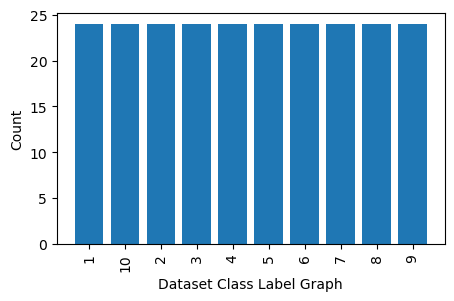

In [4]:
#number of images found for each person
#visualizing class labels count found in dataset for each person
names, count = np.unique(finger_Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (5, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [5]:
#preprocess images like shuffling and normalization
face_X = face_X.astype('float32')
face_X = face_X/255 #normalized pixel values between 0 and 1
indices = np.arange(face_X.shape[0])
np.random.shuffle(indices)#shuffle all images
face_X = face_X[indices]
face_Y = face_Y[indices]
face_Y = to_categorical(face_Y)

finger_X = finger_X.astype('float32')
finger_X = finger_X/255

indices = np.arange(finger_X.shape[0])
np.random.shuffle(indices)
finger_X = finger_X[indices]
finger_Y = finger_Y[indices]
finger_Y = to_categorical(finger_Y)

iris_X = iris_X.astype('float32')
iris_X = iris_X/255

indices = np.arange(iris_X.shape[0])
np.random.shuffle(indices)
iris_X = iris_X[indices]
iris_Y = iris_Y[indices]
iris_Y = to_categorical(iris_Y)

#split dataset into train and test
face_X_train, face_X_test, face_y_train, face_y_test = train_test_split(face_X, face_Y, test_size=0.2)
finger_X_train, finger_X_test, finger_y_train, finger_y_test = train_test_split(finger_X, finger_Y, test_size=0.2)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(iris_X_train.shape[0]))
print("20% image used to train algorithms : "+str(iris_X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 160
20% image used to train algorithms : 40


In [6]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [7]:
#functiont to calculate accuracy and other metrics
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)

In [8]:
#train VGG16 on face features
vgg16 = VGG16(input_shape=(face_X_train.shape[1], face_X_train.shape[2], face_X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg16.layers:
    layer.trainable = False
face_model = Sequential()
face_model.add(vgg16)
face_model.add(Convolution2D(32, (1 , 1), input_shape = (face_X_train.shape[1], face_X_train.shape[2], face_X_train.shape[3]), activation = 'relu'))
face_model.add(MaxPooling2D(pool_size = (1, 1)))
face_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
face_model.add(MaxPooling2D(pool_size = (1, 1)))
face_model.add(Flatten())
face_model.add(Dense(units = 256, activation = 'relu'))
face_model.add(Dense(units = face_y_train.shape[1], activation = 'softmax'))
face_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/face_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/face_weights.hdf5', verbose = 1, save_best_only = True)
    hist = face_model.fit(face_X_train, face_y_train, batch_size = 32, epochs = 20, validation_data=(face_X_test, face_y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/face_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    face_model.load_weights("model/face_weights.hdf5")   
predict = face_model.predict(face_X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(face_y_test, axis=1)
calculateMetrics("Face Features", predict, y_test1)
print("VGG16 Training on Face Features Completed")



VGG16 Training on Face Features Completed


In [9]:
#train VGG16 on finger vein features
vgg16 = VGG16(input_shape=(finger_X_train.shape[1], finger_X_train.shape[2], finger_X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg16.layers:
    layer.trainable = False
finger_model = Sequential()
finger_model.add(vgg16)
finger_model.add(Convolution2D(32, (1 , 1), input_shape = (finger_X_train.shape[1], finger_X_train.shape[2], finger_X_train.shape[3]), activation = 'relu'))
finger_model.add(MaxPooling2D(pool_size = (1, 1)))
finger_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
finger_model.add(MaxPooling2D(pool_size = (1, 1)))
finger_model.add(Flatten())
finger_model.add(Dense(units = 256, activation = 'relu'))
finger_model.add(Dense(units = finger_y_train.shape[1], activation = 'softmax'))
finger_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/finger_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/finger_weights.hdf5', verbose = 1, save_best_only = True)
    hist = finger_model.fit(finger_X_train, finger_y_train, batch_size = 32, epochs = 30, validation_data=(finger_X_test, finger_y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/finger_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    finger_model.load_weights("model/finger_weights.hdf5")   
predict = finger_model.predict(finger_X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(finger_y_test, axis=1)
calculateMetrics("Finger Features", predict, y_test1)
print("VGG16 Training on Finger Vein Features Completed")

VGG16 Training on Finger Vein Features Completed


In [10]:
#train VGG16 on Iris features
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_Y, test_size=0.2)
vgg16 = VGG16(input_shape=(iris_X_train.shape[1], iris_X_train.shape[2], iris_X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg16.layers:
    layer.trainable = False
iris_model = Sequential()
iris_model.add(vgg16)
iris_model.add(Convolution2D(32, (1 , 1), input_shape = (iris_X_train.shape[1], iris_X_train.shape[2], iris_X_train.shape[3]), activation = 'relu'))
iris_model.add(MaxPooling2D(pool_size = (1, 1)))
iris_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
iris_model.add(MaxPooling2D(pool_size = (1, 1)))
iris_model.add(Flatten())
iris_model.add(Dense(units = 256, activation = 'relu'))
iris_model.add(Dense(units = iris_y_train.shape[1], activation = 'softmax'))
iris_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/iris_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/iris_weights.hdf5', verbose = 1, save_best_only = True)
    hist = iris_model.fit(iris_X_train, iris_y_train, batch_size = 32, epochs = 20, validation_data=(iris_X_test, iris_y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/iris_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    iris_model.load_weights("model/iris_weights.hdf5")   
predict = iris_model.predict(iris_X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(iris_y_test, axis=1)
calculateMetrics("Iris Features", predict, y_test1)
print("VGG16 Training on Iris Features Completed")

VGG16 Training on Iris Features Completed


In [11]:
#calculate Features Level Fusion Accuracy
features_fusion_accuracy = 0
features_fusion_precision = 0
features_fusion_recall = 0
features_fusion_fscore = 0
for i in range(len(accuracy)):
    features_fusion_accuracy += accuracy[i]
    features_fusion_precision += precision[i]
    features_fusion_recall += recall[i]
    features_fusion_fscore += fscore[i]
print("Features Fusion Accuracy : "+str(features_fusion_accuracy/3))    
print("Features Fusion Precision: "+str(features_fusion_precision/3))    
print("Features Fusion Recall   : "+str(features_fusion_recall/3))    
print("Features Fusion FSCORE : "+str(features_fusion_fscore/3))    

Features Fusion Accuracy : 92.91666666666667
Features Fusion Precision: 92.44047619047619
Features Fusion Recall   : 94.2037037037037
Features Fusion FSCORE : 92.64068393480159


In [12]:
#now create fusion model by combining features from all 3 VGG16 models
if os.path.exists("model/all_X.txt.npy"):
    X = np.load("model/all_X.txt.npy")
    Y = np.load("model/all_Y.txt.npy")
else:
    face_X = np.load("model/faceX.txt.npy")
    face_Y = np.load("model/faceY.txt.npy")
    face_X = face_X.astype('float32')
    face_X = face_X/255
    indices = np.arange(face_X.shape[0])
    np.random.shuffle(indices)
    face_X = face_X[indices]
    face_Y = face_Y[indices]
    finger_X = np.load("model/fingerX.txt.npy")
    finger_Y = np.load("model/fingerY.txt.npy")
    finger_X = finger_X.astype('float32')
    finger_X = finger_X/255
    indices = np.arange(finger_X.shape[0])
    np.random.shuffle(indices)
    finger_X = finger_X[indices]
    finger_Y = finger_Y[indices]
    iris_X = np.load("model/irisX.txt.npy")
    iris_Y = np.load("model/irisY.txt.npy")
    iris_X = iris_X.astype('float32')
    iris_X = iris_X/255
    indices = np.arange(iris_X.shape[0])
    np.random.shuffle(indices)
    iris_X = iris_X[indices]
    iris_Y = iris_Y[indices]
    face_model = load_model("model/face_weights.hdf5")
    finger_model = load_model("model/finger_weights.hdf5")
    iris_model = load_model("model/iris_weights.hdf5")   
    face_features = Model(face_model.inputs, face_model.layers[-2].output)#create face  model
    face_features = face_features.predict(face_X)  #extracting face features from vgg16
    finger_features = Model(finger_model.inputs, finger_model.layers[-2].output)#create finger  model
    finger_features = finger_features.predict(finger_X)  #extracting finger features from vgg16
    iris_features = Model(iris_model.inputs, iris_model.layers[-2].output)#create iris  model
    iris_features = iris_features.predict(iris_X)  #extracting iris features from vgg16
    X = np.hstack((face_features, finger_features[0:100], iris_features[0:100]))#stacking all 3 face, finger and iris features
    Y = face_Y
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    Y = to_categorical(Y)
    X = np.reshape(X, (X.shape[0], 16, 16, 3))
    np.save("model/all_X.txt", X)
    np.save("model/all_Y.txt", Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
fusion_model = Sequential()#creating fusion model with multiple CNN and max pool layers
fusion_model.add(Convolution2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
fusion_model.add(MaxPooling2D(pool_size = (2, 2)))
fusion_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
fusion_model.add(MaxPooling2D(pool_size = (2, 2)))
fusion_model.add(Flatten())
fusion_model.add(Dense(units = 256, activation = 'relu'))
fusion_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
fusion_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/fusion_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/fusion_weights.hdf5', verbose = 1, save_best_only = True)
    hist = fusion_model.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/fusion_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    fusion_model.load_weights("model/fusion_weights.hdf5")   
predict = fusion_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1) 
calculateMetrics("Score Fusion Accuracy", predict, y_test1)
print("Score Fusion Accuracy : "+str(accuracy[3]))    
print("Score Fusion Precision: "+str(precision[3]))    
print("Score Fusion Recall   : "+str(recall[3]))    
print("Score Fusion FSCORE : "+str(fscore[3])) 

Score Fusion Accuracy : 100.0
Score Fusion Precision: 100.0
Score Fusion Recall   : 100.0
Score Fusion FSCORE : 100.0


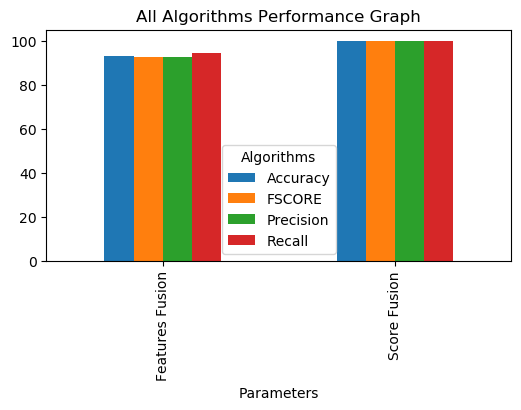

In [13]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['Features Fusion','Accuracy',features_fusion_accuracy/3],['Features Fusion','Precision',features_fusion_precision/3],['Features Fusion','Recall',features_fusion_recall/3],['Features Fusion','FSCORE',features_fusion_fscore/3],
                   ['Score Fusion','Accuracy',accuracy[3]],['Score Fusion','Precision',precision[3]],['Score Fusion','Recall',recall[3]],['Score Fusion','FSCORE',fscore[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [14]:
#generate all models for real prediction
face_model = load_model("model/face_weights.hdf5")
finger_model = load_model("model/finger_weights.hdf5")
iris_model = load_model("model/iris_weights.hdf5")   
face_model = Model(face_model.inputs, face_model.layers[-2].output)#create face  model
finger_model = Model(finger_model.inputs, finger_model.layers[-2].output)#create finger  model
iris_model = Model(iris_model.inputs, iris_model.layers[-2].output)#create iris  model
print("All Models Loaded")

All Models Loaded


In [15]:
def getImageFeatures(path):
    image = cv2.imread(path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    return img

In [16]:
#use this function to predict fish species uisng extension model
def predict(face_test_path, finger_test_path, iris_test_path):
    face_img = getImageFeatures(face_test_path)#reading face
    finger_img = getImageFeatures(finger_test_path)#reading finger
    iris_img = getImageFeatures(iris_test_path)#reading iris
    
    face_features = face_model.predict(face_img)#getting vgg16 face features
    finger_features = finger_model.predict(finger_img) #getting VGG16 finger features
    iris_features = iris_model.predict(iris_img) #getting VGG16 iris features
    #combining or stacking all 3 features
    fusion_features = np.hstack((face_features, finger_features, iris_features))
    fusion_features = np.reshape(fusion_features, (fusion_features.shape[0], 16, 16, 3))
    #using fusion model predicting person id from all features
    person_id = fusion_model.predict(fusion_features)
    person_id = np.argmax(person_id)
    person_id = person_id + 1
    
    face = cv2.imread(face_test_path)
    finger = cv2.imread(finger_test_path)
    iris = cv2.imread(iris_test_path)
    face = cv2.resize(face, (350,300))
    finger = cv2.resize(finger, (350,300))
    iris = cv2.resize(iris, (350,300))
    cv2.putText(face, 'Person ID Predicted As : '+str(person_id), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.putText(finger, 'Person ID Predicted As : '+str(person_id), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.putText(iris, 'Person ID Predicted As : '+str(person_id), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    figure, axis = plt.subplots(nrows=1, ncols=3,figsize=(10,6))
    axis[0].set_title("Face Image")
    axis[1].set_title("Finger Image")
    axis[2].set_title("Iris Image")
    axis[0].imshow(face)
    axis[1].imshow(finger)
    axis[2].imshow(iris)
    figure.tight_layout()
    plt.axis('off')
    plt.show()

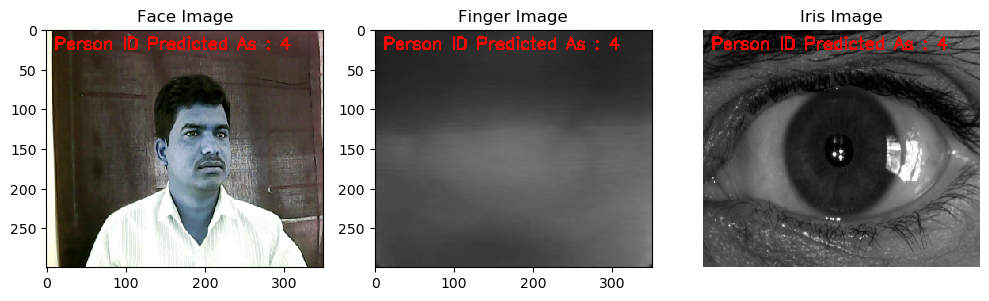

In [17]:
#call this function with all multimodal images to predict person id
predict("testImages/test1/face.jpg", "testImages/test1/vein.jpg", "testImages/test1/iris.jpg")

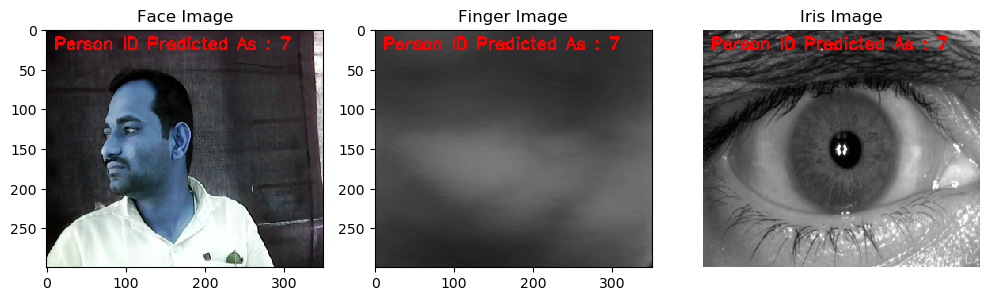

In [18]:
#call this function with all multimodal images to predict person id
predict("testImages/test2/face.jpg", "testImages/test2/vein.jpg", "testImages/test2/iris.jpg")

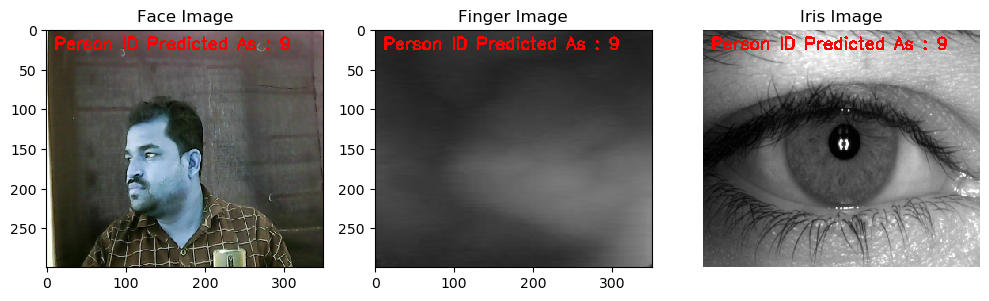

In [19]:
#call this function with all multimodal images to predict person id
predict("testImages/test3/face.jpg", "testImages/test3/vein.jpg", "testImages/test3/iris.jpg")